In [307]:
import numpy as np
import pandas as pd
import re
import ast
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Budget Data pipeline

In [308]:
#Budget Dataframe loading and pretreating

budget_path = "archive/movies_metadata.csv"

budget = pd.read_csv(
    budget_path, usecols=["id", "budget", "original_title", "release_date", "runtime"]
)

#Conversino to datetime
budget["Movie_release_year"] = pd.to_datetime(
    budget["release_date"], infer_datetime_format=True, errors="coerce"
).dt.year

#renaming for column matching in the merge
budget = budget.rename(
    columns={"original_title": "Movie_name", "runtime": "Movie_runtime"}
)

# converting '\\N' values to np.nan
budget.loc[budget["Movie_release_year"] == "\\N", "Movie_release_year"] = np.nan
budget.loc[budget["Movie_runtime"] == "\\N", "Movie_runtime"] = np.nan

#removing the rows with nan
budget = budget[budget["Movie_release_year"].notna()]

# converting release year to 'int64'
budget["Movie_release_year"] = budget["Movie_release_year"].astype("int64", errors="ignore")

# converting runtime to 'float64'
budget["Movie_runtime"] = budget["Movie_runtime"].astype("float64")

In [309]:
budget.head()

,budget,id,Movie_name,release_date,Movie_runtime,Movie_release_year
0,30000000,862,Toy Story,1995-10-30,81.0,1995
1,65000000,8844,Jumanji,1995-12-15,104.0,1995
2,0,15602,Grumpier Old Men,1995-12-22,101.0,1995
3,16000000,31357,Waiting to Exhale,1995-12-22,127.0,1995
4,0,11862,Father of the Bride Part II,1995-02-10,106.0,1995


In [310]:
print(budget.shape)
budget_counts = budget[budget["budget"].notna() & budget["budget"] != 0].copy(deep=True)
budget_counts = budget_counts["budget"].size

print("Available budget data size:", budget_counts)

(45376, 6)
Available budget data size: 45376


In [311]:
# Change the file path for the file movie.metadata.tsv
file_path = "data/movie.metadata.tsv"
# Reading the file into a pandas dataframe
movie_summaries = pd.read_csv(file_path, sep="\t", header=None)
movie_summaries.columns = ["Wikipedia movie ID",
 "Freebase_movie_ID",
 "Movie_name",
 "Movie_release_date",
 "Movie_box_office_revenue",
 "Movie_runtime",
 "Movie_languages",
 "Movie_countries",
 "Movie_genres"]

 # Remove prefix '/m/'
movie_summaries['Freebase_movie_ID'] = movie_summaries['Freebase_movie_ID'].str.replace('/m/', '')
# Create new columns for languages, countries and genres
# The data type of the new columns is list containing all possible values
# Only take the values into account for now,
# If we need the code for further analysis, just apply x.keys() instead of x.values()

movie_summaries['Movie_languages_clean'] = movie_summaries['Movie_languages'].apply(ast.literal_eval).apply(lambda x: list(x.values()))
movie_summaries['Movie_countries_clean'] = movie_summaries['Movie_countries'].apply(ast.literal_eval).apply(lambda x: list(x.values()))
movie_summaries['Movie_genres_clean'] = movie_summaries['Movie_genres'].apply(ast.literal_eval).apply(lambda x: list(x.values()))
# Extract the release year
# This column only contains the years
movie_summaries['Movie_release_year'] = movie_summaries['Movie_release_date'].str.extract(r'(\d{4})')

# Convert strings to datetime values if there are
# For the rows with only years, the value is replaced by NaT
# pd.to_datetime has a bug if the format provided is more "precise" than what is in the dataframe, it has default values and will not 
# raise an error or replace with NaT
# specifically %Y-%m-%d with year 2000 defaults to 2000-01-01, even with the exact=True argument.

movie_summaries['Movie_release_date_datetime'] = movie_summaries['Movie_release_date'].astype('str').apply(
        lambda x: pd.to_datetime(x if "-" in x else pd.NaT, errors="coerce")
)
movie_summaries = movie_summaries[~movie_summaries["Movie_release_year"].isna()]
movie_summaries["Movie_release_year"] = movie_summaries["Movie_release_year"].astype("int64")
movie_summaries.head()

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_languages_clean,Movie_countries_clean,Movie_genres_clean,Movie_release_year,Movie_release_date_datetime
0,975900,03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,2001-08-24
1,3196793,08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,2000-02-16
2,28463795,0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988,NaT
3,9363483,0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,NaT
4,261236,01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[German Language],[Germany],[Drama],1983,NaT


In [312]:
print("Movie shape:", movie_summaries.shape)
print("Budget shape:", budget.shape)

Movie shape: (74839, 14)
Budget shape: (45376, 6)


In [313]:
#Merge 

# merge 'movies' with 'budget'
movie_summaries = pd.merge(
    left=movie_summaries,
    right=budget,
    how="left",
    on=["Movie_name", "Movie_release_year", "Movie_runtime"],
)
# convert budget to float
movie_summaries["budget"] = movie_summaries["budget"].astype("float")
movie_summaries.head()


,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_languages_clean,Movie_countries_clean,Movie_genres_clean,Movie_release_year,Movie_release_date_datetime,budget,id,release_date
0,975900,03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,2001-08-24,28000000.0,10016,2001-08-24
1,3196793,08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,2000-02-16,NaN,NaN,NaN
2,28463795,0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988,NaT,NaN,NaN,NaN
3,9363483,0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,NaT,NaN,NaN,NaN
4,261236,01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[German Language],[Germany],[Drama],1983,NaT,NaN,NaN,NaN


In [314]:
print("Movie merged with budget shape", movie_summaries.shape)

Movie merged with budget shape (74845, 17)


## Budget Data Analysis

In [315]:
#How much budget data survived the merge?
budget_df= movie_summaries[movie_summaries["budget"].notna() & movie_summaries["budget"] != 0].copy(deep=True)
budget_count = budget_df["budget"].size

budget_len = movie_summaries["budget"].size

print("Available Budget data percentage:", budget_count/budget_len*100, "%")
print("Number of movies whose budget data is available:",budget_count)

Available Budget data percentage: 3.489879083439108 %
Number of movies whose budget data is available: 2612


In [316]:
movie_summaries['language_count'] = movie_summaries['Movie_languages_clean'].apply(len)
budget_df= movie_summaries[movie_summaries["budget"].notna() & movie_summaries["budget"] != 0].copy(deep=True)
budget_df_count = budget_df[['Movie_name', 'Movie_box_office_revenue', 'budget','language_count']].dropna().copy(deep=True)


Text(0, 0.5, 'Count')

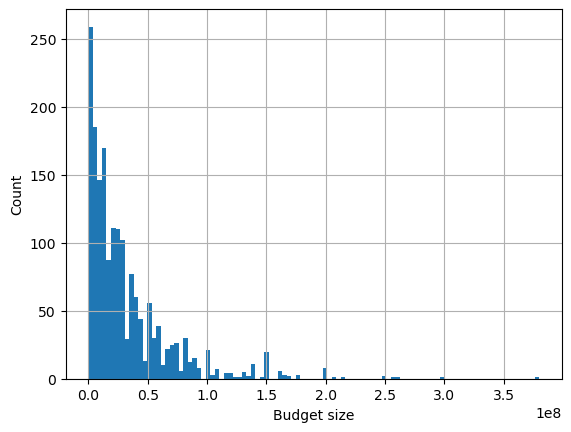

In [317]:
#Distribution plot
budget_df_count["budget"].hist(bins=100)
#plt.xscale("log")
plt.xlabel('Budget size') 
plt.ylabel('Count')

### Budget - Revenue Correlation

Text(37.597222222222214, 0.5, 'Worldwide gross revenue')

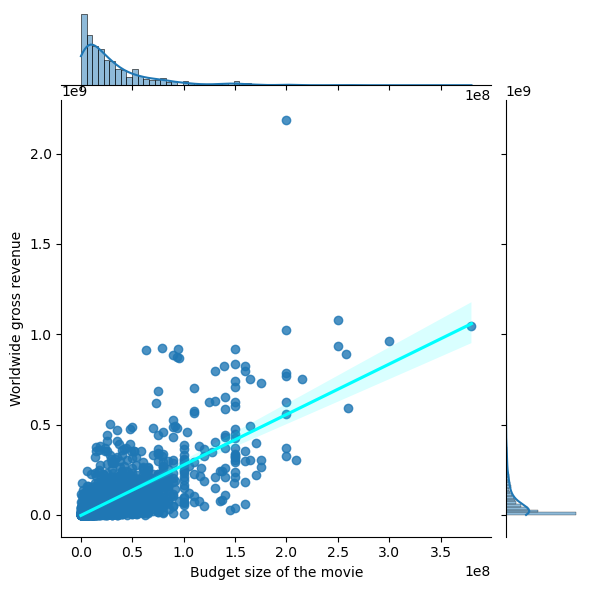

In [318]:
sns.jointplot(data = budget_df_count, x = "budget", y = 'Movie_box_office_revenue', kind="reg", joint_kws={'line_kws':{'color':'cyan'}})
plt.xlabel("Budget size of the movie")
plt.ylabel('Worldwide gross revenue')

Text(37.597222222222214, 0.5, 'Worldwide gross revenue')

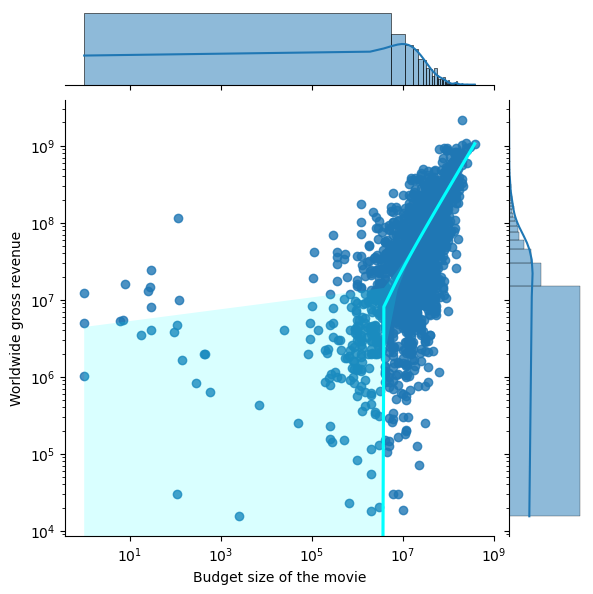

In [319]:
sns.jointplot(data = budget_df_count, x = "budget", y = 'Movie_box_office_revenue', kind="reg", joint_kws={'line_kws':{'color':'cyan'}})
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Budget size of the movie")
plt.ylabel('Worldwide gross revenue')